# This notebook will:
1. Read in AWOS site information
2. Find the Maryland stations
3. Check the years that each station are/were operational
4. Write out lines to put into download script to get data
5. Read in data and save into a combined netCDF file
6. Output a tslist file for WRF to capture towers at each location


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from mpl_toolkits.basemap import Basemap
from os import path
import glob
import xarray as xr
from timeit import default_timer as timer
import sys
sys.path.append('../../')
from pydicts.obsdict import AWOS_to_ds, ASOS_to_ds


In [28]:
fdir = '/Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/'
fname = 'isd-history.txt'
header_line = 20
nheader = header_line + 1

In [29]:
stnid = []
wbann = []
stnna = []
cntry = []
state = []
calls = []
lats  = []
lons  = []
elev  = []
stn_s = []
stn_e = []

f = open('{}{}'.format(fdir,fname),'r')

for ll,line in enumerate(f):
    if ll == header_line:
        header = line.split()
    elif ll > nheader:
        stnid.append(line[0:6])
        wbann.append(line[7:12])
        stnna.append(line[13:42].rstrip())
        cntry.append(line[43:47].rstrip())
        state.append(line[48:50].rstrip())
        calls.append(line[51:56].rstrip())
        lat = line[57:64]
        lon = line[65:73]
        elv = line[74:81]
        
        if '+' in lat: 
            lat = float(lat.replace('+',''))
        elif len(lat.strip()) > 0:
            lat = float(lat)
        else:
            lat = np.nan

        if '+' in lon: 
            lon = float(lon.replace('+',''))
        elif len(lon.strip()) > 0:
            lon = float(lon)
        else:
            lon = np.nan

        if '+' in elv: 
            elv = float(elv.replace('+',''))
        elif len(elv.strip()) > 0:
            elv = float(elv)
        else:
            elv = np.nan    
            
        lats.append(lat)
        lons.append(lon)
        elev.append(elv)
        stn_s.append(datetime.strptime(line[82:90],'%Y%m%d'))
        stn_e.append(datetime.strptime(line[91:99],'%Y%m%d'))
#    if ll > 35: 
#        print(cntry)
#        wefwef 
    
f.close()


In [30]:
stn_dict = {'station_id' : stnid,
            'wbann_id'   : wbann,
            'station_n'  : stnna,
            'country'    : cntry,
            'state'      : state,
            'call_sign'  : calls,
            'lat'        : lats,
            'lon'        : lons,
            'elevation'  : elev,
            'date_start' : stn_s,
            'date_end'   : stn_e}

stn_df = pd.DataFrame(data=stn_dict)

maryland_stations = stn_df.loc[stn_df['state'] == 'MD']

md_lats = maryland_stations.lat.values
md_lons = maryland_stations.lon.values


/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


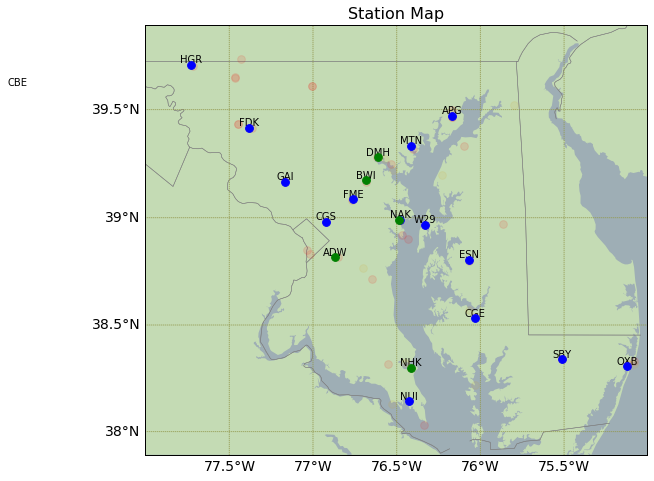

In [31]:
btwn_2000_2020 = []
btwn_2007_2020 = []
btwn_2010_2020 = []

fig, ax = plt.subplots(1, 1, figsize=(9, 8))

center_lat = 38.690760
center_lon = -76.401987
m = Basemap(projection='merc',lat_ts=center_lat,
            llcrnrlat=center_lat-0.8,urcrnrlat=center_lat+1.2,
            llcrnrlon=center_lon-1.6,urcrnrlon=center_lon+1.4, 
            resolution='h', ax=ax)
m.fillcontinents(color="#c4dbb4", lake_color='#9eaeb5')
m.drawmapboundary(fill_color="#9eaeb5")
#m.drawcoastlines(color='gray')
m.drawstates(color='gray')

parallels = np.arange(38.0,40.1,0.5)
meridians = np.arange(-77.5,-74.9,0.5)
m.drawparallels(parallels,labels=[True,False,True,False],color='#93994d',size=14)
m.drawmeridians(meridians,labels=[True,False,False,True],color='#93994d',size=14)

# Station Labels:
for index, row in maryland_stations.iterrows():
    zo = 5
    if row['date_start'].year <= 2000 and row['date_end'].year > 2019:
        c = 'green'
        a = 1.0
        btwn_2000_2020.append(row['station_n'])
        show_txt = True
    elif row['date_start'].year <= 2007 and row['date_end'].year > 2019:
        c = 'blue'
        a = 1.0
        btwn_2007_2020.append(row['station_n'])
        show_txt = True
    elif row['date_start'].year <= 2010 and row['date_end'].year > 2019:
        c = 'goldenrod'
        a = 0.1
        btwn_2010_2020.append(row['station_n'])
        show_txt = False
    else:
        a = 0.1
        zo = 3
        c = 'r'
        show_txt = False
    x, y = m(row['lon'], row['lat'])
    ax.scatter(x,y,zorder=zo,c=c,s=60,alpha=a,lw=None)
    if show_txt: ax.text(x,y*1.0001,row['call_sign'][1:],ha='center',va='bottom')
ax.tick_params(size=14)
ax.set_title('Station Map',size=16)
plt.show()

In [32]:
with open('/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/ASOS_list.txt') as f:
    asos_list = f.read().splitlines()

for ss,stn in enumerate(asos_list):
    asos_list[ss] = stn[:4]

asos_list = np.unique(asos_list)

stn_ds = stn_df.to_xarray()

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


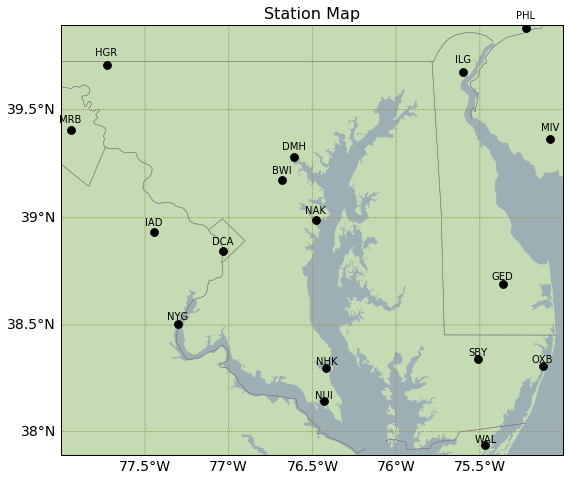

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))

center_lat = 38.690760
center_lon = -76.401987
m = Basemap(projection='merc',lat_ts=center_lat,
            llcrnrlat=center_lat-0.8,urcrnrlat=center_lat+1.2,
            llcrnrlon=center_lon-1.6,urcrnrlon=center_lon+1.4, 
            resolution='h', ax=ax)
m.fillcontinents(color="#c4dbb4", lake_color='#9eaeb5')
m.drawmapboundary(fill_color="#9eaeb5")
#m.drawcoastlines(color='gray')
m.drawstates(color='gray')

parallels = np.arange(38.0,40.1,0.5)
meridians = np.arange(-77.5,-74.9,0.5)
m.drawparallels(parallels,labels=[True,False,True,False],color='#93994d',size=14)
m.drawmeridians(meridians,labels=[True,False,False,True],color='#93994d',size=14)

# Station Labels:
asos_call_signs = []
for ss,stn in enumerate(asos_list):
    asos_stn = stn_ds.isel(index=np.where(stn_ds.call_sign==stn)[0])
    stn_lat = asos_stn.lat.data
    stn_lon = asos_stn.lon.data
    if len(stn_lat) == 0:
        stn_lat = np.nan
        stn_lon = np.nan
    else:
        stn_lat = stn_lat[0]
        stn_lon = stn_lon[0]
    if ((stn_lat >= center_lat-0.8) & (stn_lat <= center_lat+1.2)) &\
        ((stn_lon >= center_lon-1.6) & (stn_lon <= center_lon+1.4)):
        x, y = m(stn_lon, stn_lat)
        ax.scatter(x,y,zorder=4,c='k',s=60,alpha=1.0,lw=None)
        call_sign = asos_stn.call_sign.data
        if len(call_sign) == 0:
            call_sign = '    '
        else:
            call_sign = call_sign[0]
        asos_call_signs.append(call_sign)
        ax.text(x,y*1.02,call_sign[1:],ha='center',va='bottom')
ax.tick_params(size=14)
ax.set_title('Station Map',size=16)
plt.show()

In [34]:
asos_call_signs.remove('KDMH')

print('"' + '" "'.join(asos_call_signs) + '"')

"KBWI" "KDCA" "KGED" "KHGR" "KIAD" "KILG" "KMIV" "KMRB" "KNAK" "KNHK" "KNUI" "KNYG" "KOXB" "KPHL" "KSBY" "KWAL"


# FME and DMH (Tipton and Downtown Baltimore, resp.) had no data...

In [35]:
station_list = list(np.concatenate([btwn_2000_2020,btwn_2007_2020]))

station_list.append('WASHINGTON DULLES INTERNATION')
station_list.append('CULPEPER REGIONAL AIRPORT')

station_list.remove('BALTIMORE DOWNTOWN')

In [36]:
loop_str = []
for stn in station_list:
    station = stn_df.loc[stn_df['station_n'] == stn]
    if len(station['station_id']) > 1:
        station = maryland_stations.loc[maryland_stations['station_n'] == stn]
        if len(station) == 0:
            station = stn_df.loc[stn_df['station_n'] == stn]
            station = station.loc[station['date_end']== max(station['date_end'])]
    print(stn,station['call_sign'].values)
    if station['call_sign'].values != '':
        loop_str.append(station['call_sign'].values[0][1:])

NAVAL AIR STATION ['KNHK']
BALTIMORE-WASHINGTON INTL AIR ['KBWI']
ANDREWS AIR FORCE BASE AIRPOR ['KADW']
U.S. NAVAL ACADEMY ['']
GAITHERSBURG MONTGOMERY COUNT ['KGAI']
GREATER CUMBERLAND REGIONAL A ['KCBE']
BAY BRIDGE AIRPORT ['KW29']
FREDERICK MUNICIPAL ARPT ['KFDK']
ANNAPOLIS UNITED STATES NAVAL ['KNAK']
CAMBRIDGE DORCHESTER AIRPORT ['KCGE']
COLLEGE PARK AP ['KCGS']
SALBRY-OCN CTY WICO RGNL AP ['KSBY']
EASTON/NEWNAM FIELD AIRPORT ['KESN']
PHILLIPS ARMY AIRFIELD ['KAPG']
TIPTON ['KFME']
HGRTWN RGNL-R.HNSON FLD AP ['KHGR']
MARTIN STATE AIRPORT ['KMTN']
WEBSTER NAVAL OUTLYING FIELD ['KNUI']
OCEAN CITY MUNICIPAL ARTP ['KOXB']
GARRETT COUNTY AIRPORT ['']
WASHINGTON DULLES INTERNATION ['KIAD']
CULPEPER REGIONAL AIRPORT ['KCJR']


In [37]:
print('"',*loop_str, sep='" "')

"" "NHK" "BWI" "ADW" "GAI" "CBE" "W29" "FDK" "NAK" "CGE" "CGS" "SBY" "ESN" "APG" "FME" "HGR" "MTN" "NUI" "OXB" "IAD" "CJR


In [38]:
station_list

['NAVAL AIR STATION',
 'BALTIMORE-WASHINGTON INTL AIR',
 'ANDREWS AIR FORCE BASE AIRPOR',
 'U.S. NAVAL ACADEMY',
 'GAITHERSBURG MONTGOMERY COUNT',
 'GREATER CUMBERLAND REGIONAL A',
 'BAY BRIDGE AIRPORT',
 'FREDERICK MUNICIPAL ARPT',
 'ANNAPOLIS UNITED STATES NAVAL',
 'CAMBRIDGE DORCHESTER AIRPORT',
 'COLLEGE PARK AP',
 'SALBRY-OCN CTY WICO RGNL AP',
 'EASTON/NEWNAM FIELD AIRPORT',
 'PHILLIPS ARMY AIRFIELD',
 'TIPTON',
 'HGRTWN RGNL-R.HNSON FLD AP',
 'MARTIN STATE AIRPORT',
 'WEBSTER NAVAL OUTLYING FIELD',
 'OCEAN CITY MUNICIPAL ARTP',
 'GARRETT COUNTY AIRPORT',
 'WASHINGTON DULLES INTERNATION',
 'CULPEPER REGIONAL AIRPORT']

In [39]:
for stn in station_list:
    station = stn_df.loc[stn_df['station_n'] == stn]
    if station['call_sign'].values[0] != '' and station['call_sign'].values[0] != 'KFME':
        print('if [ "$site" == "{2}" ]\n\tthen site_num="{0}-{1}"\nfi'.format(
                                station['station_id'].values[0],station['wbann_id'].values[0],
                                station['call_sign'].values[0][1:]))
    else:
        station_list.remove(stn)

if [ "$site" == "NHK" ]
	then site_num="724040-13721"
fi
if [ "$site" == "BWI" ]
	then site_num="724060-93721"
fi
if [ "$site" == "ADW" ]
	then site_num="745940-13705"
fi
if [ "$site" == "CBE" ]
	then site_num="720355-03732"
fi
if [ "$site" == "W29" ]
	then site_num="720384-00124"
fi
if [ "$site" == "FDK" ]
	then site_num="722081-13730"
fi
if [ "$site" == "NAK" ]
	then site_num="722158-99999"
fi
if [ "$site" == "CGE" ]
	then site_num="722218-00356"
fi
if [ "$site" == "CGS" ]
	then site_num="722244-00358"
fi
if [ "$site" == "SBY" ]
	then site_num="723980-93720"
fi
if [ "$site" == "ESN" ]
	then site_num="724043-03756"
fi
if [ "$site" == "APG" ]
	then site_num="724057-13701"
fi
if [ "$site" == "MTN" ]
	then site_num="724067-93744"
fi
if [ "$site" == "NUI" ]
	then site_num="725514-03757"
fi
if [ "$site" == "OXB" ]
	then site_num="745946-93786"
fi
if [ "$site" == "CJR" ]
	then site_num="723098-93798"
fi


# Use above lines to run 'get_data.sh' in AWOS dir

In [46]:
fsave_str = '{}2007_to_2020/AWOS_{}_{}to{}.nc'
year_range = np.arange(2007,2020,1)

nstations = len(station_list)
if path.exists('{}/AWOS_2007to2020.nc'.format(fdir)):
    print('loading in full dataset!')
    ds_stn = xr.open_dataset('{}AWOS_2019to2020.nc'.format(fdir))
else:
    ds_stn0 = [[]]*nstations
    for ss,stn in enumerate(station_list):
        station = stn_df.loc[stn_df['station_n'] == stn]
        
        print('Looking for {}'.format(fsave_str.format(fdir,station['call_sign'].values[0][1:],
                                                       year_range[0],year_range[-1])))

        if path.exists(fsave_str.format(fdir,station['call_sign'].values[0][1:],year_range[0],year_range[-1])):
            print('found {} data... loading.'.format(stn))
            ds_stn0[ss] = xr.open_dataset(fsave_str.format(fdir,station['call_sign'].values[0][1:],
                                                           year_range[0],year_range[-1]))
        else:
            print('loading in AWOS data for {}'.format(stn))

            ds_stn0[ss] = AWOS_to_ds(fdir, station['call_sign'].values[0][1:], year_range=year_range[0:], 
                                    lat=station['lat'].values[0], lon=station['lon'].values[0],
                                    saveds=True)

    for ss,stn in enumerate(ds_stn0):
        if ss == 0:
            _, index = np.unique(stn['datetime'], return_index=True)
            ds_stn = stn.isel(datetime=index)
        else:
            print('getting index')
            _, index = np.unique(stn['datetime'], return_index=True)
            print('selecting index')
            dsf1 = stn.isel(datetime=index)
            print('merging...')

            ds_stn = dsf1.merge(ds_stn)
        print('done with {}'.format(ss))

    ds_stn['cldc'] = ds_stn['cldc'].astype('str')

    
    onshore_dict = {'ADW':[np.nan,np.nan], 
                    'APG':[50,200], 
                    'BWI':[60,160], 
                    'CBE':[np.nan,np.nan], 
                    'CGE':[np.nan,np.nan], 
                    'CGS':[np.nan,np.nan], 
                    'CJR':[np.nan,np.nan], 
                    'ESN':[np.nan,np.nan], 
                    'FDK':[np.nan,np.nan], 
                    'GAI':[np.nan,np.nan], 
                    'HGR':[np.nan,np.nan], 
                    'IAD':[np.nan,np.nan], 
                    'MTN':[70,190], 
                    'NAK':[20,190], 
                    'NHK':[0,170], 
                    'NUI':[0,150], 
                    'OXB':[np.nan,np.nan], 
                    'SBY':[np.nan,np.nan], 
                    'W29':[np.nan,np.nan]}


    nstations = np.shape(ds_stn.get_index('station'))[0]
    ds_stn['onshore_min'] = (['station'],[None]*nstations)
    ds_stn['onshore_max'] = (['station'],[None]*nstations)

    for stn in ds_stn.station.data: 
        ds_stn.onshore_min.loc[stn] = onshore_dict[stn][0]
        ds_stn.onshore_max.loc[stn] = onshore_dict[stn][1]    
        
    region = []
    for ss in ds_stn['station'].values:
        if np.isnan(float(ds_stn.sel(station=ss).onshore_min.values)):
            region.append('inland')
        else:
            region.append('coastal')

    ds_stn['region'] = (['station'],region)

    ds_stn.to_netcdf('{}AWOS_2007to2020.nc'.format(fdir),'w')


Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/2007_to_2020/AWOS_NHK_2007to2019.nc
found NAVAL AIR STATION data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/2007_to_2020/AWOS_BWI_2007to2019.nc
found BALTIMORE-WASHINGTON INTL AIR data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/2007_to_2020/AWOS_ADW_2007to2019.nc
found ANDREWS AIR FORCE BASE AIRPOR data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/2007_to_2020/AWOS_GAI_2007to2019.nc
found GAITHERSBURG MONTGOMERY COUNT data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/2007_to_2020/AWOS_CBE_2007to2019.nc
found GREATER CUMBERLAND REGIONAL A data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/2007_to_2020/AWOS_W29_2007to2019.nc
found BAY BRIDGE AIRPORT data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/2007_to_2020/AWOS_FDK_2007to2019.nc
found FREDERICK MUN

KeyboardInterrupt: 

# Write AWOS locations to tslist file:

In [748]:
ds_stn

<xarray.Dataset>
Dimensions:      (datetime: 1367544, station: 15)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2006-12-31T19:00:00 ... 2020-01-01T04:55:00
  * station      (station) object 'BWI' 'DCA' 'GED' 'HGR' ... 'PHL' 'SBY' 'WAL'
    lon          (station) float64 -76.68 -77.03 -75.36 ... -75.23 -75.51 -75.47
    lat          (station) float64 39.17 38.85 38.69 39.71 ... 39.87 38.34 37.94
Data variables:
    wdir         (station, datetime) float64 90.0 90.0 90.0 90.0 ... nan nan nan
    wspd         (station, datetime) float64 6.0 5.0 6.0 5.0 ... nan nan nan nan
    cldc         (station, datetime) <U8 'FEW,OVC' 'FEW,OVC' ... 'nan' 'nan'
    pcip         (station, datetime) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    temp         (station, datetime) float64 7.0 7.0 7.0 7.0 ... nan nan nan nan
    dwpt         (station, datetime) float64 6.0 6.0 6.0 6.0 ... nan nan nan nan
    onshore_min  (station) object 60 nan nan nan nan nan ... 20 nan nan nan nan
    onshore_m

In [750]:
from mmctools.wrf.utils import write_tslist_file

write_tslist_file('/Users/hawbecke/Research/Chesapeake/Data/WRF/ASOStslist',
                  twr_names=ds_stn.station.values,
                  twr_abbr=ds_stn.station.values,
                  lon=ds_stn.lon.values,
                  lat=ds_stn.lat.values)

# Read 1-minute ASOS

In [24]:
def check_files(fdir,stn,lat,lon,year_range=None,onshore_min=None,onshore_max=None,
                saveds=False,set_vrb_wdir=True,fsave_str=None,asos_type='1min'):
    file_list = sorted(glob.glob('{}*{}*.dat'.format(fdir,stn)))
    for ff,fname in enumerate(file_list):
        file_list[ff] = fname.replace('6405','{}').replace('6406','{}')
    file_list = np.unique(file_list)
    if year_range is not None:
        new_file_list = []
        for yy in year_range:
            year_list = []
            for ff in file_list:
                if str(yy) in ff:
                    new_file_list.append(ff)
                    year_list.append(ff)
            if len(year_list) == 12:
                print('{} has all months'.format(stn))
            else:
                print('{} is missing months in {}'.format(stn,yy))
                for ff in year_list: print(ff)
        file_list = new_file_list


In [25]:
asos_1min_dir = '/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/'
asos_1min_files = sorted(glob.glob('{}640*2019*'.format(asos_1min_dir)))

asos_1min_stations = asos_1min_files.copy()
for ff,file in enumerate(asos_1min_files):
    asos_1min_stations[ff] = file.split('/')[-1][5:9]

asos_1min_stations = np.unique(asos_1min_stations)

ystart = 2019
yend   = 2020
stn_save_str  = '{}ASOS_{}{}to{}.nc'
full_save_str = '{}ASOS_{}to{}.nc'.format(asos_1min_dir,ystart,yend)
year_range = np.arange(ystart,yend,1)

nstations = len(asos_1min_stations)

In [26]:
for stn in asos_1min_stations:
    test = check_files(asos_1min_dir, stn=stn, year_range=np.arange(ystart,yend+1), 
                      lat=stn_lat, lon=stn_lon,
                      saveds=True,fsave_str=stn_save_str,
                      asos_type='5min')
    print('\n\n')
    

KBWI has all months
KBWI is missing months in 2020



KDCA has all months
KDCA is missing months in 2020



KGED is missing months in 2019
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201901.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201902.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201903.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201904.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201905.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201906.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201907.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201908.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KGED201909.dat
KGED is missing months in 2020



KHGR has all months
KHGR is missing months in 2020



KIAD has all months
KIAD is missing months in 2020



KILG has all months
KILG is missing months i

In [27]:
from pydicts.obsdict import ASOS_to_ds

In [31]:
def ASOS_to_ds(fdir,stn,lat,lon,year_range=None,onshore_min=None,onshore_max=None,
               saveds=False,set_vrb_wdir=True,fsave_str=None,asos_type='1min'):
    file_list = sorted(glob.glob('{}*{}*.dat'.format(fdir,stn)))
    for ff,fname in enumerate(file_list):
        file_list[ff] = fname.replace('6405','{}').replace('6406','{}')
    file_list = np.unique(file_list)
    if year_range is not None:
        new_file_list = []
        for yy in year_range:
            for ff in file_list:
                if str(yy) in ff:
                    new_file_list.append(ff)
        file_list = new_file_list
    if asos_type == '1min':
        for ff,fname in enumerate(file_list):
            print(fname)
            got_6405,got_6406 = False,False
            if path.exists(fname.format(6405)):
                got_6405 = True
            else:
                print('missing 6405... filling with nan')
            if path.exists(fname.format(6406)):
                got_6406 = True
            else:
                print('missing 6406... filling with nan')

            if got_6405:
                df_6405 = read_ASOS_1min(fname.format(6405))
            if got_6406:
                df_6406 = read_ASOS_1min(fname.format(6406))
            if got_6405 and got_6406:
                df0 = pd.merge(df_6405,df_6406,how='outer',on=['datetime','station'])

            if ff == 0:
                df = df0
            else:
                df = pd.concat([df,df0])
    elif asos_type == '5min':
        for ff,fname in enumerate(file_list):
            print(fname)
            df0 = read_ASOS_5min(fname)
            if ff == 0:
                df = df0
            else:
                df = pd.concat([df,df0])            
    ds = df.to_xarray() 
    ds = ds.assign_coords({'station':stn[1:]}).expand_dims('station')
    ds['lon'] = (['station'],[lon])
    ds['lat'] = (['station'],[lat])
    if onshore_min is not None: ds['onshore_min'] = (['station'],[onshore_min])
    if onshore_max is not None: ds['onshore_max'] = (['station'],[onshore_max])
    ds = ds.assign_coords({'lon':ds.lon, 'lat':ds.lat})
    if saveds: ds.to_netcdf(fsave_str.format(fdir,stn,year_range[0],year_range[-1]))

    return(ds)

In [32]:
def read_ASOS_5min(file_loc, weak_wind_dir_correction=True):
    '''
    Read in 5-minute ASOS data from ftp://ftp.ncdc.noaa.gov/pub/data/asos-fivemin/
    '''
    def get_wspd_and_wdir(wind):
        if len(wind) == 0:
            wind = '999'
        else:
            wind = wind[0]
        wind = wind.replace('KT','').replace('G',' ').split()
        if len(wind) == 0:
            wdir = np.nan
            wspd = np.nan
        else:
            if len(wind[0]) == 5:
                wdir = wind[0][:3]
                wspd = wind[0][3:]
                try:
                    wdir = float(wdir)
                except:
                    wdir = np.nan
                try:
                    wspd = float(wspd)
                except:
                    wspd = np.nan
            else:
                wdir = np.nan
                wspd = np.nan
        return(wdir,wspd)

    def get_temp_and_dwpt(tntd):
        if len(tntd) > 1:
            for tt in tntd:
                tt_split = tt.split('/')
                if len(tt_split) == 2:
                    if (len(tt_split[0].replace('M','')) == 2) and (len(tt_split[1].replace('M','')) == 2):
                        tmpdpt = tt
        elif len(tntd) == 1:
            tmpdpt = tntd[0]
            tmpdpt = tmpdpt.split('/')
        else:
            tmpdpt = ['999','999']
        if len(tmpdpt[0].replace('M','')) == 2:
            try:
                temp = float(tmpdpt[0].replace('M','-').replace('O','0').replace('B','0'))
            except:
                print(tmpdpt)
                temp = np.nan
        else:
            temp = np.nan
        if len(tmpdpt[1].replace('M','')) == 2:
            try:
                dwpt = float(tmpdpt[1].replace('M','-'))
            except:
                print(tmpdpt)
                dwpt = np.nan
        else:
            dwpt = np.nan
        return(temp,dwpt)
    
    def get_precip(pcip):
        if pcip == []:
            pcp = 0.0
        else:
            pcp = 1.0
        return(float(pcp))
    
    def get_cloud_coverage(cldc):
        clouds = []
        if len(cldc) > 1:
            for cc in cldc:
                clouds.append(cc[:3])
            clouds = ','.join(clouds)
        elif len(cldc) == 1:
            clouds = cldc[0][:3]
        else:
            clouds = ' '
        return(clouds)
        
        
        
    var_dict = {  'station': [],
                 'datetime': [],
                     'wdir': [],
                     'wspd': [],
                     'cldc': [],
                     'pcip': [],
                     'temp': [],
                     'dwpt': []
               }
    stn = file_loc.split('/')[-1].split('K')[-1][:3]
    f = open(file_loc,'r')
    line_count = 0
    for ll,line in enumerate(f):
        line = line.replace('{}"'.format(stn),'{} '.format(stn))
        line = line.split()
        if len(line[1]) > 26:
            date = line[1][:26]
            time = line[1][27:]
            line[1] = date
            line.insert(2,time)
      
        if len(line) > 5:

            lst_h = int(line[2][:2])
            try:
                gmt_h = int(line[5][2:4].replace('P','0'))
            except:
                if var_dict['datetime'][ll-1].minute < 55:
                    gmt_h = var_dict['datetime'][ll-1].hour
                else:
                    gmt_h = var_dict['datetime'][ll-1].hour + 1
            time_change = gmt_h-lst_h
            if time_change < 0:
                time_change = time_change+24
            date_time = datetime.strptime('{} {}'.format(line[1][3:11],line[2][:7]),'%Y%m%d %H:%M:%S')
            var_dict['datetime'].append(date_time + pd.to_timedelta(time_change,'H'))
            var_dict['station'].append(line[1][:3])
            wind = []
            tntd = []
            pcip = []
            cldc = []
            for vv in line:
                if vv[-2:] == 'KT':
                    wind.append(vv)
                if ('/' in vv) and (len(vv.replace('/','').replace('M','')) == 4):
                    tntd.append(vv)
                if (vv[-2:] == 'RA') or (vv[-2:] == 'SN') and (len(vv) <= 3):
                    pcip.append(vv)
                if ('CLR' in vv) or ('FEW' in vv) or ('SCT' in vv) or ('BKN' in vv) or ('OVC' in vv):
                    cldc.append(vv)

            wdir,wspd = get_wspd_and_wdir(wind)
            temp,dwpt = get_temp_and_dwpt(tntd)
            precip    = get_precip(pcip)
            clouds    = get_cloud_coverage(cldc)
            var_dict['wdir'].append(wdir)
            var_dict['wspd'].append(wspd*0.514444)
            var_dict['temp'].append(temp)
            var_dict['dwpt'].append(dwpt)
            var_dict['pcip'].append(precip)
            var_dict['cldc'].append(clouds)
    f.close()
    df = pd.DataFrame.from_dict(var_dict).set_index('datetime')

    return(df)                 

In [70]:
if path.exists('{}ASOS_{}to{}A.nc'.format(asos_1min_dir,ystart,yend)):
    print('loading in full dataset!')
    ds_stn = xr.open_dataset('{}ASOS_{}to{}.nc'.format(asos_1min_dir,ystart,yend))
else:
    ds_stn0 = [[]]*nstations
    for ss,stn in enumerate(asos_1min_stations):
        print('Looking for {}'.format(stn_save_str.format(asos_1min_dir,stn,ystart,yend)))

        if path.exists(stn_save_str.format(asos_1min_dir,stn,ystart,yend)):
            print('found {} data... loading.'.format(stn))
            ds_stn0[ss] = xr.open_dataset(stn_save_str.format(asos_1min_dir,stn,ystart,yend))
        else:
            print('loading in ASOS data for {}'.format(stn))
            asos_stn = stn_ds.isel(index=np.where(stn_ds.call_sign==stn)[0])
            stn_lat = asos_stn.lat.data
            stn_lon = asos_stn.lon.data
            if len(stn_lat) == 0:
                stn_lat = np.nan
                stn_lon = np.nan
            else:
                stn_lat = stn_lat[0]
                stn_lon = stn_lon[0]
            start = timer()
            ds_stn0[ss] = ASOS_to_ds(asos_1min_dir, stn=stn, year_range=year_range, 
                                     lat=stn_lat, lon=stn_lon,
                                     saveds=True,fsave_str=stn_save_str,
                                     asos_type='5min')
            end = timer()
            print(end - start)
    
    for ss,stn in enumerate(ds_stn0):
        if ss == 0:
            _, index = np.unique(stn['datetime'], return_index=True)
            ds_stn = stn.isel(datetime=index)
            ds_stn = ds_stn.resample(datetime='5min').nearest(tolerance="5m")

        else:
            print('getting index')
            _, index = np.unique(stn['datetime'], return_index=True)
            print('selecting index')
            dsf1 = stn.isel(datetime=index)
            print('merging...')
            dsf1 = dsf1.resample(datetime='5min').nearest(tolerance="5m")
            ds_stn = dsf1.merge(ds_stn)
        print('done with {}'.format(ss))

    onshore_dict = {'BWI':[60,160], 
                    'DCA':[np.nan,np.nan],
                    'GED':[np.nan,np.nan], 
                    'HGR':[np.nan,np.nan], 
                    'IAD':[np.nan,np.nan], 
                    'ILG':[np.nan,np.nan], 
                    'MIV':[np.nan,np.nan], 
                    'MRB':[np.nan,np.nan], 
                    'NAK':[20,190],
                    'NHK':[0,170],
                    'NUI':[0,150],
                    'OXB':[np.nan,np.nan], 
                    'PHL':[np.nan,np.nan], 
                    'SBY':[np.nan,np.nan], 
                    'WAL':[np.nan,np.nan]}

    nstations = np.shape(ds_stn.get_index('station'))[0]
    ds_stn['onshore_min'] = (['station'],[None]*nstations)
    ds_stn['onshore_max'] = (['station'],[None]*nstations)

    for stn in ds_stn.station.data: 
        ds_stn.onshore_min.loc[stn] = onshore_dict[stn][0]
        ds_stn.onshore_max.loc[stn] = onshore_dict[stn][1]    

    region = []
    for ss in ds_stn['station'].values:
        if np.isnan(float(ds_stn.sel(station=ss).onshore_min.values)):
            region.append('inland')
        else:
            region.append('coastal')

    ds_stn['region'] = (['station'],region)

    ds_stn['pcip'] = ds_stn.pcip.astype('float')
    ds_stn['cldc'] = ds_stn.cldc.astype('str')

    #ds_stn.to_netcdf('{}ASOS_{}to{}.nc'.format(asos_1min_dir,ystart,yend),'w')


Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/ASOS_KBWI2019to2020.nc
loading in ASOS data for KBWI
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201901.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201902.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201903.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201904.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201905.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201906.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201907.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201908.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201909.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201910.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/64010KBWI201911.dat
/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/

In [747]:
'{}ASOS_{}to{}.nc'.format(asos_1min_dir,ystart,yend)

'/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/ASOS_2007to2019.nc'

In [71]:
ds_stn.to_netcdf('{}ASOS_{}to{}.nc'.format(asos_1min_dir,ystart,yend),'w')


# Change old onshore min/max vals

In [82]:
test = xr.open_dataset('/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/ASOS_2019to2020.nc')

onshore_dict = {'BWI':[60,160], 
                'DCA':[np.nan,np.nan],
                'GED':[np.nan,np.nan], 
                'HGR':[np.nan,np.nan], 
                'IAD':[np.nan,np.nan], 
                'ILG':[np.nan,np.nan], 
                'MIV':[np.nan,np.nan], 
                'MRB':[np.nan,np.nan], 
                'NAK':[20,190],
                'NHK':[0,170],
                'NUI':[0,150],
                'OXB':[np.nan,np.nan], 
                'PHL':[np.nan,np.nan], 
                'SBY':[np.nan,np.nan], 
                'WAL':[np.nan,np.nan]}

for stn in test.station.data: 
    test.onshore_min.loc[stn] = onshore_dict[stn][0]
    test.onshore_max.loc[stn] = onshore_dict[stn][1]
    print(str(stn),test.sel(station=stn).onshore_min.data,test.sel(station=stn).onshore_max.data)

test.to_netcdf('/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/ASOS_2019to2020.nc')